In [1]:
! chmod 600 /content/kaggle.json

In [2]:
! KAGGLE_CONFIG_DIR=/content kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification

100% 3.58G/3.58G [03:00<00:00, 21.4MB/s]
100% 3.58G/3.58G [03:00<00:00, 21.3MB/s]


In [3]:
import zipfile
zip_file = zipfile.ZipFile('/content/fruits-fresh-and-rotten-for-classification.zip', 'r')
zip_file.extractall('/tmp/')

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

In [5]:
train_path = "/tmp/dataset/train"
test_path = "/tmp/dataset/test"

In [6]:
# Preprocessing dan augmentation data latih
train_datagen = ImageDataGenerator(rescale=1./255)
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(150, 150),
                                                 batch_size=32,
                                                 class_mode='sparse')

Found 10901 images belonging to 6 classes.


In [7]:
# Preprocessing data uji
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='sparse')

Found 2698 images belonging to 6 classes.


In [8]:
model = Sequential()
model.add(Conv2D(32, 3, padding="same", activation="relu", input_shape=(150, 150, 3)))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(6, activation="softmax"))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

In [10]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callback untuk mengurangi learning rate saat validasi loss stagnan
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
# Callback untuk menghentikan pelatihan saat tidak ada peningkatan dalam validasi loss
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(training_set,
                    epochs=10,
                    verbose=1,
                    validation_data=test_set,
                    callbacks=[reduce_lr, early_stop])

Epoch 1/10
341/341 [==============================] - 67s 164ms/step - loss: 0.6019 - accuracy: 0.7789 - val_loss: 0.2315 - val_accuracy: 0.9251 - lr: 0.0010
Epoch 2/10
341/341 [==============================] - 60s 175ms/step - loss: 0.2321 - accuracy: 0.9160 - val_loss: 0.2007 - val_accuracy: 0.9266 - lr: 0.0010
Epoch 3/10
341/341 [==============================] - 55s 162ms/step - loss: 0.1609 - accuracy: 0.9435 - val_loss: 0.1300 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 4/10
341/341 [==============================] - 54s 158ms/step - loss: 0.1004 - accuracy: 0.9637 - val_loss: 0.1910 - val_accuracy: 0.9207 - lr: 0.0010
Epoch 5/10
341/341 [==============================] - 55s 161ms/step - loss: 0.0820 - accuracy: 0.9699 - val_loss: 0.1081 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 6/10
341/341 [==============================] - 54s 159ms/step - loss: 0.0736 - accuracy: 0.9750 - val_loss: 0.1661 - val_accuracy: 0.9366 - lr: 0.0010
Epoch 7/10
341/341 [==============================] 

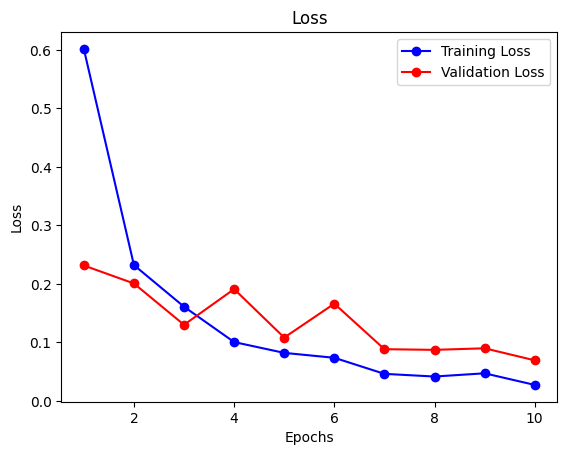

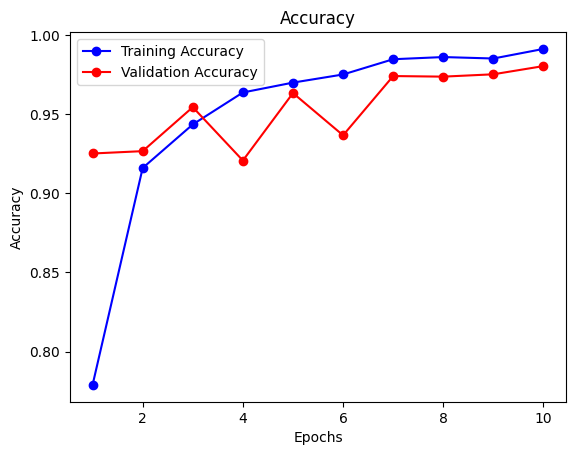

In [11]:
import matplotlib.pyplot as plt

# Mendapatkan history dari pelatihan model
history_dict = history.history

# Mengambil nilai loss dan akurasi dari set pelatihan dan validasi
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Menghitung jumlah epoch
epochs = range(1, len(train_loss) + 1)

# Plot loss
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot akurasi
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [12]:
from google.colab import files

model.save('model_v2.1.0.h5')
files.download('model_v2.1.0.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving rotten orange2.jpg to rotten orange2.jpg
1/1 [==============================] - 0s 219ms/step
rotten orange2.jpg is a Rotten Orange


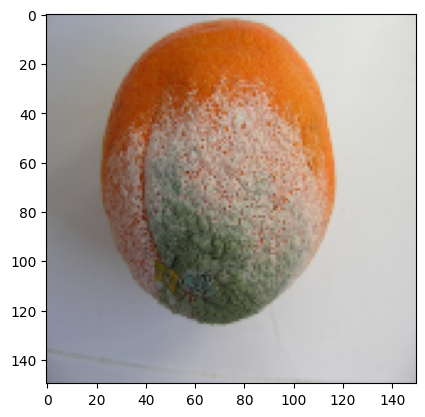

In [13]:
import numpy as np

%matplotlib inline
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = tf.keras.utils.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)
  x = tf.keras.utils.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  arr = model.predict(images, batch_size=10)
  if arr[0][0]==1:
    labels='Fresh Apple'
  elif arr[0][1]==1:
    labels='Fresh Banana'
  elif arr[0][2]==1:
    labels='Fresh Orange'
  elif arr[0][3]==1:
    labels='Rotten Apple'
  elif arr[0][4]==1:
    labels='Rotten Banana'
  elif arr[0][5]==1:
    labels='Rotten Orange'
print('{} is a {}'.format(fn, labels))